## LCL Calculation Comparison
Compares computing LCL from average profile, to average of LCL computed on each day.

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.utils.moist_physics import saturation_vapor_pressure, clausius_clapeyron_factor, sphum_sat, \
    sphum_from_dew, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory, get_approx_terms, get_sensitivity_factors, get_cape_approx, get_temp_adiabat
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.convection.base import lcl_metpy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from geocat.comp.interpolation import interp_hybrid_to_pressure
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
from geopy.distance import geodesic
from scipy.ndimage import distance_transform_edt
import copy
import os

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

### Load Online computation
This is where the variables are computed for each day, and then the average is taken over all these values.

In [4]:
quant = 95
exp_name = 'pre_industrial'
exp_path = f'./{exp_name}/output.nd2'
exp_labels = ['Online', 'Offline']      # Offline means all calcs performed on av temperature profile
# Get LCL info computed on each day, and then averaged over
var = ['TREFHT', 'QREFHT', 'PS', 'T', 'Z3', 'lapse_below_lcl', 'lapse_above_lcl', 'T_lcl', 'T_at_lcl', 'p_lcl', 'p_at_lcl', 'Z3_lcl', 'Z3_at_lcl']
ds = [xr.load_dataset(exp_path).isel(plev=0).sel(quant=quant)[var].load()]
ds.append(ds[0][[]])        # append empty array for av after

In [5]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.load_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['LANDFRAC', 'PHIS']]
invariant_data = invariant_data.reindex_like(ds[0]['PS'], method="nearest", tolerance=0.01).load()
land = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']>0.5)*0+1
ocean = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']<=0.5)*0+1
weights = np.cos(np.deg2rad(invariant_data.lat))
z2m = invariant_data.PHIS/g + 2

### Get Offline values
This is where the variables are computed from the individually averaged variables.

In [6]:
# Compute from averaged quantities
ds[1]['p_lcl'], ds[1]['T_lcl'] = lcl_metpy(ds[0].TREFHT, ds[0].QREFHT, ds[0].PS)
ds[1]['Z3_lcl'] = z2m + (ds[0].TREFHT - ds[1]['T_lcl']) / lapse_dry

In [7]:
# Get info for pressure computation
def get_lev_info(archive_dir='/Users/joshduffield/Documents/StAndrews/Isca/cesm/archive',
                 exp_name='test', year_files=41, hist_file=1):
    # Use test dataset to get
    ds = isca_tools.cesm.load_dataset(exp_name, archive_dir=archive_dir,
                                      hist_file=hist_file, year_files=year_files)
    return ds.hyam.isel(time=0), ds.hybm.isel(time=0), float(ds.P0.isel(time=0))
hyam, hybm, p0 = get_lev_info()

In [8]:
exp_path_prof = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/av_profile/above_TREFHTquant'
ds_prof = xr.merge([xr.load_dataset(f"{exp_path_prof}/T/{exp_name}/output.nd2").sel(quant=quant)[['T']],
                    xr.load_dataset(f"{exp_path_prof}/Z/{exp_name}/output.nd2").sel(quant=quant)[['Z3']]])

In [9]:
# Get info on pressure levels from average profile
def get_TZp_at_lcl(p_lcl, p_surf):
    ds_interp = interp_var_at_pressure(ds_prof, p_lcl, p_surf, hyam, hybm, p0)
    return ds_interp.T, ds_interp.Z3, ds_interp.plev
ds[1]['T_at_lcl'], ds[1]['Z3_at_lcl'], ds[1]['p_at_lcl'] = get_TZp_at_lcl(ds[1].p_lcl, ds[0].PS)
ds[1]['T'] = interp_hybrid_to_pressure(ds_prof.T, ds[0]['PS'], hyam, hybm, p0, np.atleast_1d(ds[0].plev)).isel(plev=0)
ds[1]['Z3'] = interp_hybrid_to_pressure(ds_prof.Z3, ds[0]['PS'], hyam, hybm, p0, np.atleast_1d(ds[0].plev)).isel(plev=0)
ds[1]['TREFHT'] = ds[0].TREFHT
ds[1]['PS'] = ds[0].PS

In [10]:
for i in range(len(ds)):
    ds[i]['lapse_below_lcl_recon'] = get_bulk_lapse_rate(ds[i].TREFHT, ds[i].T_at_lcl, ds[i].PS, ds[i].p_at_lcl) * 1000
    ds[i]['lapse_above_lcl_recon'] = get_bulk_lapse_rate(ds[i].T_at_lcl, ds[i].T, ds[i].p_at_lcl, 500*100) * 1000
    # where lapse below surface, compute above lapse from entire column
    # ds[i]['lapse_above_lcl_recon'] = ds[i]['lapse_above_lcl_recon'].where(~np.isnan(ds[i].T_at_lcl),
    #                                                                       get_bulk_lapse_rate(ds[i].TREFHT, ds[i].T, ds[i].PS, 500*100) * 1000)

## Comparison of calculation
### LCL Pressure
LCL pressure seems to be systematically over-estimated by the offline method, but the difference is less than 5%.

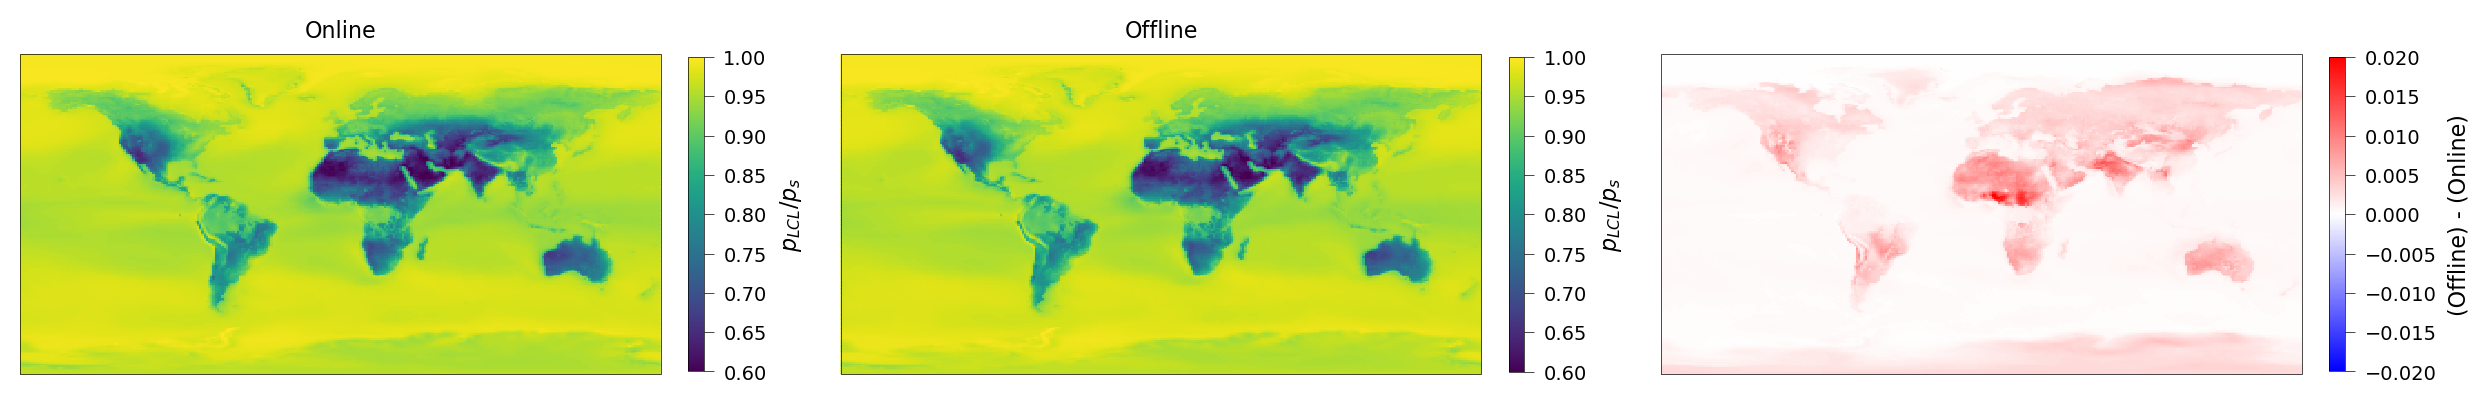

In [11]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
isca_tools.plot.fig_resize(fig, 15)
for i in range(2):
    im = ax[i].pcolormesh(ds[i].lon, ds[i].lat, (ds[i].p_lcl/ds[i].PS), transform=ccrs.PlateCarree(), vmin=0.6, vmax=1)
    fig.colorbar(im, ax=ax[i], fraction=0.023, pad=0.04, label='$p_{LCL}/p_s$')
    ax[i].set_title(exp_labels[i])
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, (ds[1].p_lcl/ds[1].PS) - (ds[0].p_lcl/ds[0].PS),
                      transform=ccrs.PlateCarree(), cmap='bwr', vmin=-0.02, vmax=0.02)
fig.colorbar(im, ax=ax[2], fraction=0.023, pad=0.04, label=f'({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()

### LCL Temperature
As is expected, the offline computation also over-estimates the LCL temperature.

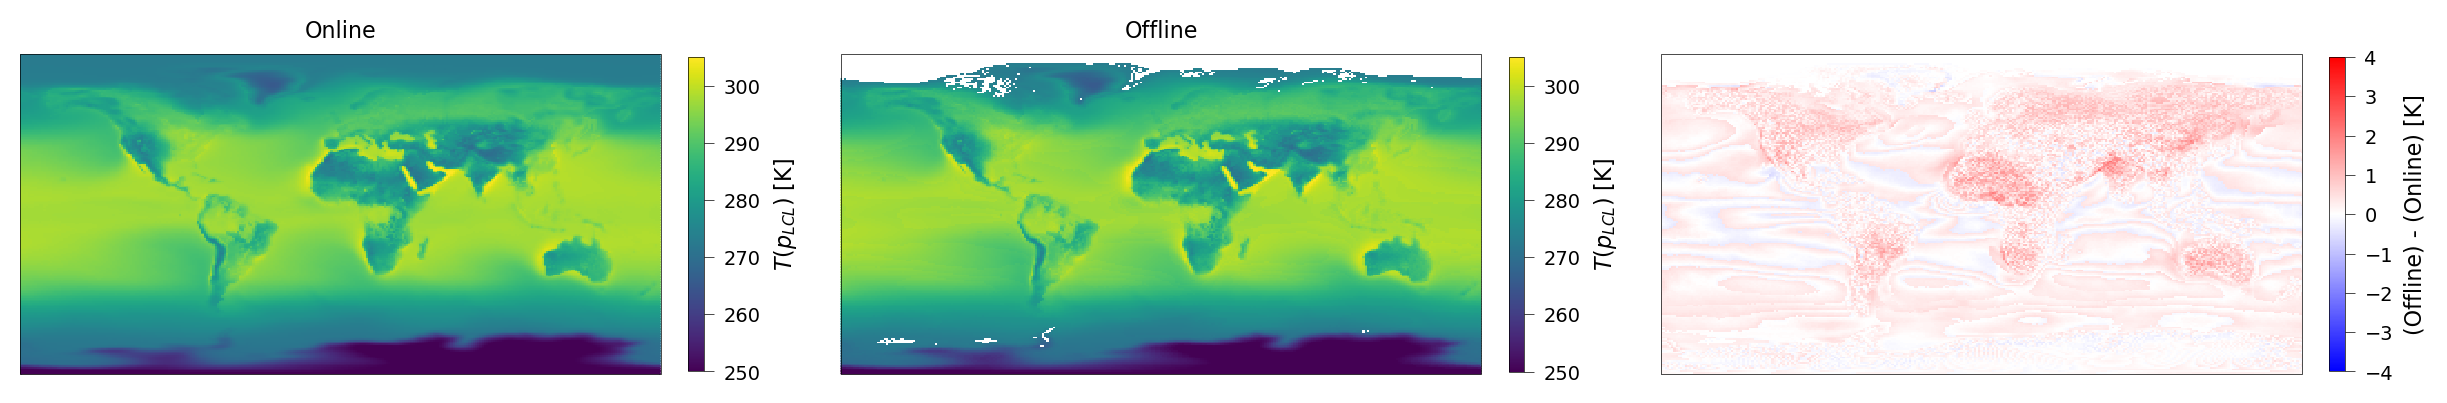

In [12]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
isca_tools.plot.fig_resize(fig, 15)
for i in range(2):
    im = ax[i].pcolormesh(ds[i].lon, ds[i].lat, ds[i].T_at_lcl, transform=ccrs.PlateCarree(), vmin=250, vmax=305)
    fig.colorbar(im, ax=ax[i], fraction=0.023, pad=0.04, label='$T(p_{LCL})$ [K]')
    ax[i].set_title(exp_labels[i])
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, ds[1].T_at_lcl - ds[0].T_at_lcl,
                      transform=ccrs.PlateCarree(), cmap='bwr', vmin=-4, vmax=4)
fig.colorbar(im, ax=ax[2], fraction=0.023, pad=0.04, label=f'({exp_labels[1]}) - ({exp_labels[0]}) [K]')
plt.show()

### Lapse rate below LCL
In regions where the LCL is significantly higher than the surface, the value of it is significantly smaller for the offline calculation at high latitudes.

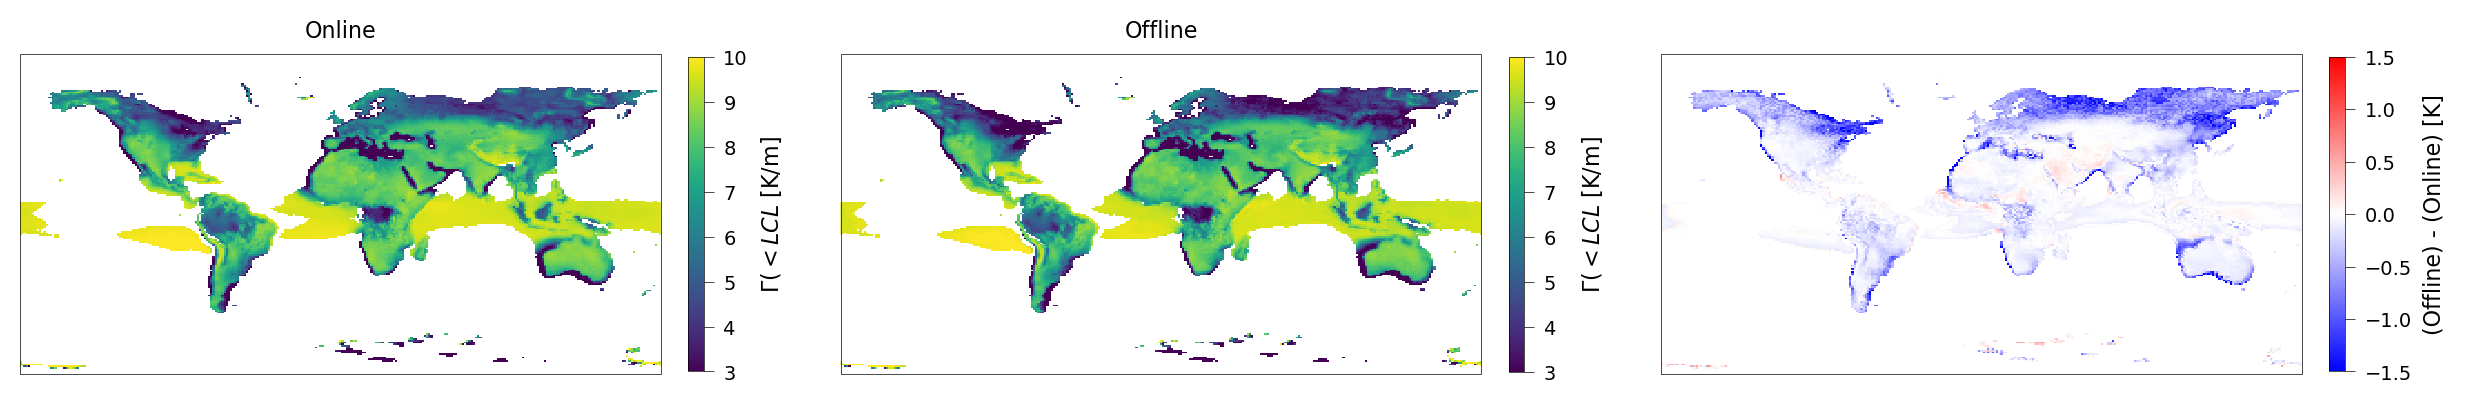

In [13]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
isca_tools.plot.fig_resize(fig, 15)
mask = (ds[1].p_lcl/ds[1].PS) < 0.95
for i in range(2):
    im = ax[i].pcolormesh(ds[i].lon, ds[i].lat, ds[i].lapse_below_lcl_recon.where(mask), transform=ccrs.PlateCarree(), vmin=3, vmax=10)
    fig.colorbar(im, ax=ax[i], fraction=0.023, pad=0.04, label='$\Gamma(<LCL})$ [K/m]')
    ax[i].set_title(exp_labels[i])
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, ds[1].lapse_below_lcl_recon.where(mask) - ds[0].lapse_below_lcl_recon.where(mask),
                      transform=ccrs.PlateCarree(), cmap='bwr', vmin=-1.5, vmax=1.5)
fig.colorbar(im, ax=ax[2], fraction=0.023, pad=0.04, label=f'({exp_labels[1]}) - ({exp_labels[0]}) [K]')
plt.show()

### Lapse rate above the LCL
Above the LCL, the lapse rates are more similar between the two methods.

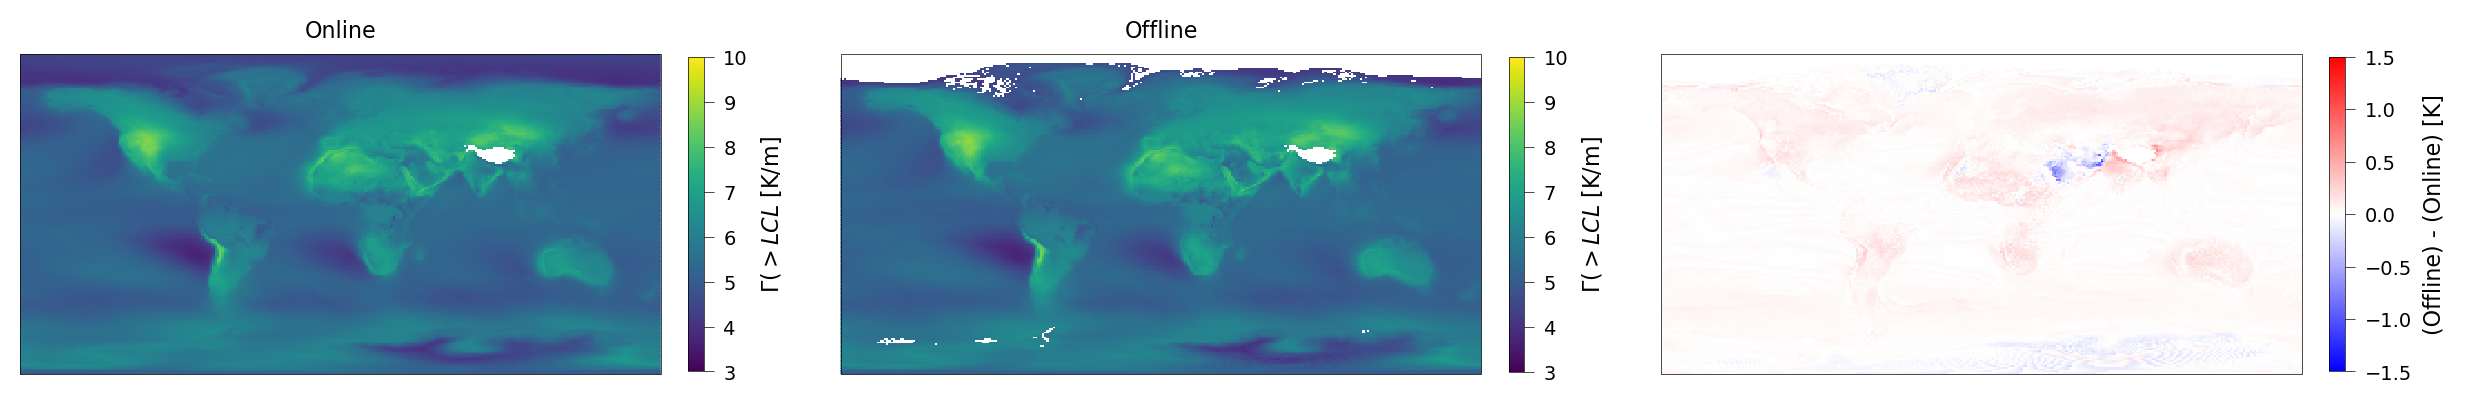

In [14]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
isca_tools.plot.fig_resize(fig, 15)
mask = (ds[1].plev/ds[1].p_lcl) < 0.95
for i in range(2):
    im = ax[i].pcolormesh(ds[i].lon, ds[i].lat, ds[i].lapse_above_lcl_recon.where(mask), transform=ccrs.PlateCarree(), vmin=3, vmax=10)
    fig.colorbar(im, ax=ax[i], fraction=0.023, pad=0.04, label='$\Gamma(>LCL})$ [K/m]')
    ax[i].set_title(exp_labels[i])
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, ds[1].lapse_above_lcl_recon.where(mask) - ds[0].lapse_above_lcl_recon.where(mask),
                      transform=ccrs.PlateCarree(), cmap='bwr', vmin=-1.5, vmax=1.5)
fig.colorbar(im, ax=ax[2], fraction=0.023, pad=0.04, label=f'({exp_labels[1]}) - ({exp_labels[0]}) [K]')
plt.show()

### Example Temperature Profile

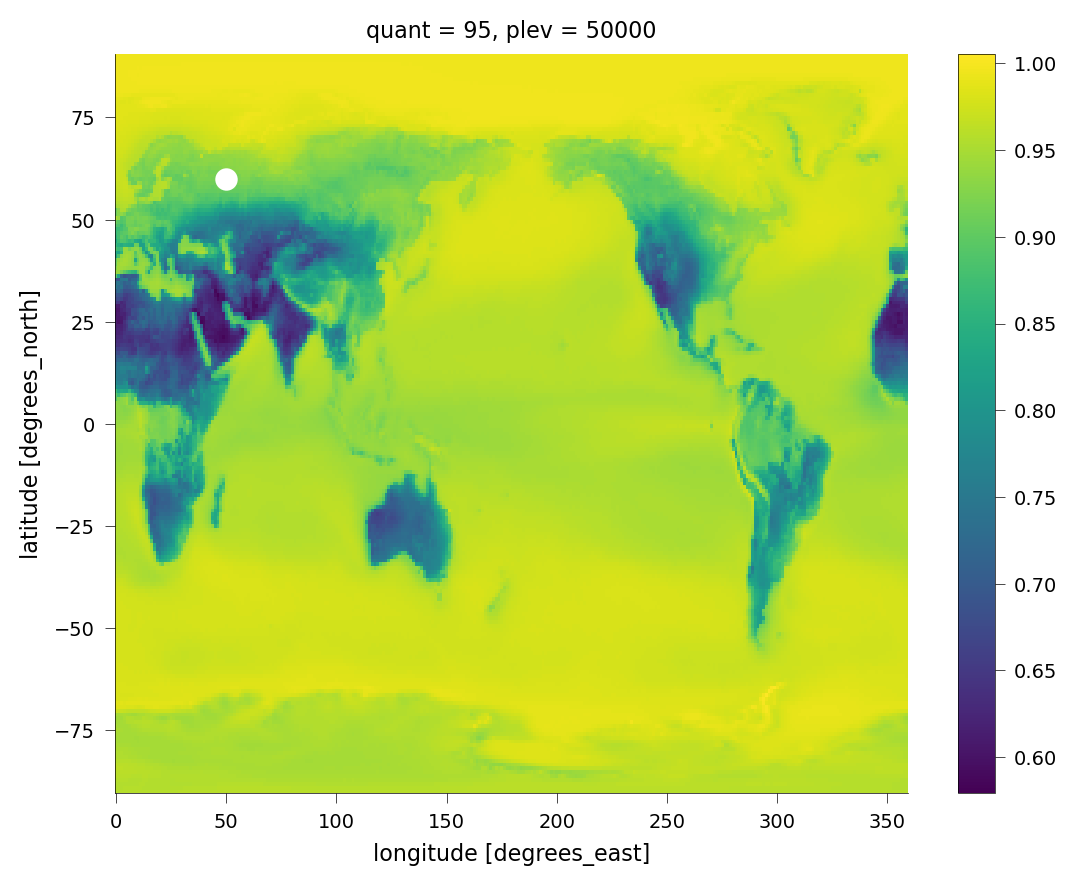

In [31]:
lat_plot = 60
lon_plot = 50
ds_prof_use = ds_prof.sel(lat=lat_plot, lon=lon_plot, method='nearest')
ds_prof_use['z2m'] = z2m.sel(lat=lat_plot, lon=lon_plot, method='nearest')
ds_use = [ds[i].sel(lat=lat_plot, lon=lon_plot, method='nearest') for i in range(2)]
p_levels_use = isca_tools.cesm.get_pressure(ds_use[0].PS, p0, hyam, hybm)/100

show_location = True    # show location of coordinate considering on top of lcl
if show_location:
    (ds[0].p_lcl/ds[0].PS).plot()
    plt.scatter(ds_use[0].lon, ds_use[0].lat, color='w', s=50)
    plt.show()

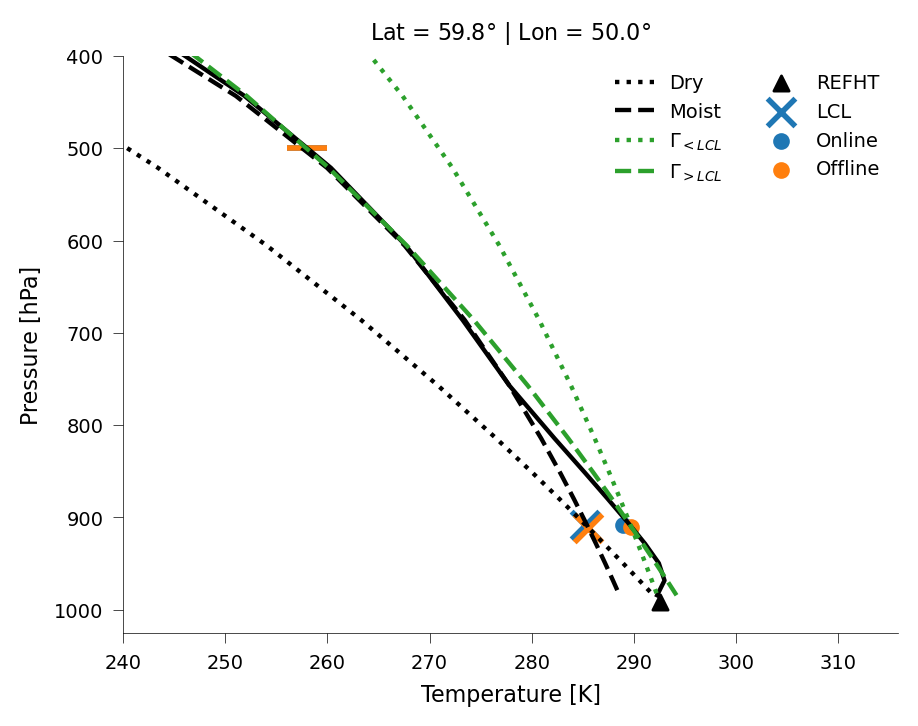

In [32]:
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, 5)
ax.plot(ds_prof_use.T, p_levels_use, color='k')
temp_profile_dry = isca_tools.convection.dry_profile_temp(float(ds_use[0].TREFHT), float(ds_use[0].PS), p_levels_use.values*100)
# temp_profile_dry = isca_tools.convection.dry_profile_temp(float(ds_prof_use.T[-2]), p_levels_use.values[-2]*100, p_levels_use.values*100)
ax.plot(temp_profile_dry, p_levels_use, color='k', linestyle=':', label='Dry')
temp_profile_moist = isca_tools.convection.moist_profile(float(ds_use[1].T_lcl), float(ds_use[1].p_lcl), p_levels_use.values*100)
ax.plot(temp_profile_moist, p_levels_use, color='k', linestyle='--', label='Moist')
temp_prof_below_lcl = reconstruct_temp(ds_use[1].TREFHT, p_levels_use*100, p_levels_use*100, float(ds_use[1].PS),
                                       float(ds_use[1].lapse_below_lcl_recon)/1000, float(ds_use[1].lapse_below_lcl_recon)/1000)
ax.plot(temp_prof_below_lcl, p_levels_use, linestyle=':', label='$\Gamma_{<LCL}$', color='C2')
temp_prof_above_lcl = reconstruct_temp(ds_use[1].T_at_lcl, p_levels_use*100, p_levels_use*100, float(ds_use[1].p_at_lcl),
                                       float(ds_use[1].lapse_above_lcl_recon)/1000, float(ds_use[1].lapse_above_lcl_recon)/1000)
ax.plot(temp_prof_above_lcl, p_levels_use, linestyle='--', label='$\Gamma_{>LCL}$', color='C2')
ax.scatter(ds_use[0].TREFHT,ds_use[0].PS/100, color='k', marker='^', s=30, label='REFHT')
# plt.scatter(ds_use.TREFHT, z2m.sel(lat=lat_plot, lon=lon_plot, method='nearest'))
for i in range(2):
    ax.scatter(ds_use[i].T_lcl, ds_use[i].p_lcl/100, color=f'C{i}', marker='x', label='LCL' if i==0 else None, s=100, lw=2)
    ax.scatter(ds_use[i].T_at_lcl, ds_use[i].p_at_lcl/100, color=f'C{i}', marker='.', label=exp_labels[i], s=100)
    ax.scatter(ds_use[i].T, 500, color=f'C{i}', marker='_', s=200, lw=2)
ax.invert_yaxis()
ax.set_ylim(ds[0].PS.max()/100, 400)
ax.set_xlim(240, ds[0].TREFHT.max())
isca_tools.plot.update_linewidth(fig)
ax.legend(ncol=2)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [hPa]')
ax.set_title(f'x={quant} | Lat = {ds_use[0].lat:.1f}$\degree$ | Lon = {ds_use[0].lon:.1f}$\degree$')
plt.show()